# Todo

- Think about contributing assortativity module to lg
- Learn how to use Gadfly
    - Consider storing relevant indices in a dict so that the memory can stay in the same place
    - e.g. {'BA'=>(0,100)} (owtte)
    - motifs   
- degree mixing matrix for digraphs (just pick, eg, out degree)
- work out what A'A is for a network
    
    
# NB:

- Matrices can be entered with [a b; c d]: cannot combine commas and semicolons
- Thoughts: Need to make a progress bar - can we do that with Jupyter?
- Storage of data - how? dict with hash of filename? JLD? metadata?

In [1]:
# todo: job sizes, etc
# @everywhere macro seems not to work?
macro p(s)
    quote
        $(esc(parse("fetch.([@spawn " * "$s"[2:end] * ")")))
    end
end#cro p(s)

@p (macro with 1 method)

In [4]:
push!(LOAD_PATH,pwd())

#import PyPlot
#const plt = PyPlot # There's no "as" keyword
#plt.svg(true)
import Combinatorics
@everywhere const cb = Combinatorics

import GraphPlot
@everywhere const gp = GraphPlot

import LightGraphs
@everywhere const lg = LightGraphs

import ScikitLearn

import DataFrames
@everywhere const df = DataFrames

import Gadfly
const gf = Gadfly

import IterTools
@everywhere const it = IterTools

import YAML

gf.set_default_plot_size(8gf.inch,6gf.inch)

# Python style +
Base.:+(x::String,y::String) = string(x,y)
Base.:+(x,y::String) = string(x,y)
Base.:+(x::String,y) = string(x,y)
# There'll always be an England
zeroes = zeros
#addprocs()
const UoM_purple = "#660099"
const UoM_grey = "#999999"
const UoM_yellow = "#FFCC33"
include("offline-laptop/mykavosh/kavosh.jl")
include("./blfeats/blfeats.jl")

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] uuid4(::MersenneTwister) at ./deprecated.jl:57
 [3] msg_header at /home/olie/.julia/v0.6/IJulia/src/msg.jl:18 [inlined]
 [4] msg_pub(::IJulia.Msg, ::String, ::Dict{String,String}, ::Dict{String,Any}) at /home/olie/.julia/v0.6/IJulia/src/msg.jl:30 (repeats 2 times)
 [5] send_stream(::String) at /home/olie/.julia/v0.6/IJulia/src/stdio.jl:172
 [6] send_stdio(::String) at /home/olie/.julia/v0.6/IJulia/src/stdio.jl:130
 [7] (::Base.##302#303{IJulia.#send_stderr,Timer})() at ./event.jl:436
while loading /home/olie/Dropbox/working_dir/julia/blfeats/blfeats.jl, in expression starting on line 278


blFeats

In [5]:
@everywhere module blGraphs
import LightGraphs
const lg = LightGraphs
#export GraphHolder (only needed for "using" etc)
type GraphHolder
    name::String
    graphs::Array{lg.SimpleGraphs.AbstractSimpleGraph}
end

Base.getindex(g::GraphHolder, inds...) = g.graphs[inds...]
Base.length(g::GraphHolder) = Base.length(g.graphs)

function GraphHolder(name::String,graph_type::Function,args::Tuple,n::Integer)
    graphs = [graph_type(args...) for i=1:n]
    GraphHolder(name,graphs)
end

function getmatrices(g::GraphHolder,mat::Function,args::Tuple=())
    return fetch.([@spawn mat(graph,args...) for graph in g.graphs])
end


# Work out what this does for directed graphs
function degree_mixing_matrix(g::lg.SimpleGraphs.AbstractSimpleGraph)
    # Consider using lg.degree - but this seems quicker
    deglist = []
    for neighbours in g.fadjlist
        push!(deglist,length(neighbours))
    end

    tuples = Array{Array{Int64,1},1}() # this is a bit quicker if they are not tuples
    for (node, neighbours) in enumerate(g.fadjlist)
        for neighbour in neighbours
            push!(tuples,
               [deglist[node],deglist[neighbour]]
            )
        end
    end

    # This part feels like it should be slow
    I = [t[1] for t in tuples]
    J = [t[2] for t in tuples]
    V = ones(length(tuples))
    
    # Magic here:
    # test[i,j] = sum(V[k]) \
    # for all k such that I[k]=i,J[k]=j i.e, tuples[k] are the co-ordinates of test, with entries V[k], and duplicates are added
    test = sparse(I,J,V) 

    test ./= sum(test)
    return test
end

# Feels slow. I must be able to do this without reallocating, right?
function pad(mat,newrows,newcols)
    y,x = size(mat)
    padded = zeros(y+newrows,x+newcols)
    padded[1:y,1:x] = mat
    padded
end

function pad(mat,shape)
    newrows, newcols = (shape[1] - size(mat)[1], shape[2] - size(mat)[2])
    pad(mat,newrows,newcols)
end

function padmatrices(mats)
    shapes = [size(m) for m in mats]
    maxrows = max([s[1] for s in shapes]...)
    maxcols = max([s[2] for s in shapes]...)
    maxdims = (maxrows,maxcols)
    result = []
    for m in mats
        push!(result,pad(m,maxdims))
    end
    result
end

## This doesn't work
function relabel_graph(g, mapping::Dict)
    newg = lg.Graph(lg.nv(g))
    for edge in lg.edges(g)
        newedge = lg.SimpleGraphs.SimpleEdge(mapping[edge.src],mapping[edge.dst])
        lg.add_edge!(newg,newedge)
    end
    return newg
end

function less_than_rand_tie(l,r)
    if l==r
        return rand(Bool)
    else
        return l < r
    end
end

function relabel_graph(g,func::Function)
    relabel_graph(g,Dict(zip(sort(lg.vertices(g),by=func),lg.vertices(g))))
    #lt=less_than_rand_tie)))) 
end

function relabel_graph_by_degree(g)
    tg = relabel_graph(g,x->rand())
    return relabel_graph(tg,x->lg.degree(tg,x))
end

end

function getdatamatandstuff(graphModels,func,padfunc,args)
    datamat = []
    arrays = []
    labels = []
    for graphs in graphModels
        myarrays = blGraphs.getmatrices(graphs,func,args)
        push!(arrays,myarrays...)
        push!(labels,[graphs.name for g in graphs.graphs]...)#..., "Suf", "Suf_huge"]...)
    end
    datamat = padfunc(arrays)
    
    return (datamat,arrays,labels)
end

kavoshpadfunc(dicts) = array_from_motif_dicts(dicts)[1]
matpadfunc(mats2pad) = [full(m)[:] for m in blGraphs.padmatrices(mats2pad)]

matpadfunc (generic function with 1 method)

In [18]:
# Problems with motifs: directed / undirected varients of motifs
# are more closely related than suggested -> perhaps we should automatically undirect all motifs?

In [19]:
# Is there any way to correct for density? z-score, maybe?

In [6]:
function nodiags(mat)
    # Multiply each element by: ((1, if empty, or 0 if non-empty)*(1 if on diagonal, 0 otherwise))
    mat.*.!(map((x)->x!=0,mat) .&Bool.(eye(mat)))
end

nodiags (generic function with 1 method)

In [21]:
# what on earth was this for?
#blFeats.Feature("motif_3",rand,kavosh.getsubgraphs).getfunction(lg.barabasi_albert(10,2),3)

In [7]:
function plotmodellabels(model,labels,colours=[],dimensions=[1,2])
    mydata = ScikitLearn.transform(model, datamat)
    thedataframe =  df.DataFrame(x = mydata[:,dimensions[1]],y = mydata[:,dimensions[2]],Type = labels);
    pcaplot = gf.plot(
        thedataframe,x="x",y="y",
        color=colours,
        #label="Type",
        #gf.Geom.hexbin(xbincount=100, ybincount=100), # this is pretty cool
        gf.Guide.xlabel("First principal component"),
        gf.Guide.ylabel("Second principal component"),
        gf.Theme(panel_stroke="black",
            grid_color="white",
            key_title_color="black",
            key_label_color="black",key_label_font_size=8gf.pt,
            minor_label_color="black",minor_label_font_size=10gf.pt,
            major_label_color="black",major_label_font_size=10gf.pt,
            highlight_width=0.4gf.pt,
            discrete_highlight_color=(x)->"black"
        ),
       # gf.Geom.label(position=:below,hide_overlaps=false),
       # gf.Geom.point
    )#; gf.draw(gf.PDF("eco_vs_konect.pdf",8gf.inch,6gf.inch),pcaplot)
    return (pcaplot, thedataframe)
end
    
function plotdatamatlabels(datamat,labels,colors=[])
    @ScikitLearn.sk_import decomposition: PCA
    model = PCA(n_components=3)
    ScikitLearn.fit!(model, datamat)
    (pcaplot, thedataframe) = plotmodellabels(model,labels,colours)
    return (pcaplot, model, thedataframe)
end

plotdatamatlabels (generic function with 2 methods)

In [8]:
gs = blFeats.loadall();

In [9]:
unique([get(g.meta,"category","Uncategorised") for g in gs])
#plotdatamatlabels(blFeats.getdatamat(gs,"motif_4"),[get(g.meta,"category","Uncategorised") for g in gs])

17-element Array{String,1}:
 "HumanSocial"   
 "Social"        
 "Infrastructure"
 "Animal"        
 "Affiliation"   
 "Lexical"       
 "Hyperlink"     
 "Metabolic"     
 "Interaction"   
 "Communication" 
 "OnlineContact" 
 "Trophic"       
 "HumanContact"  
 "Misc"          
 "Generated"     
 "Computer"      
 "Feature"       

In [10]:
function findgraph(q,graphs)
    for (k,v) in enumerate(graphs)
        if contains(v.meta["name"],q) return (k,v) end
    end
end

findgraph (generic function with 1 method)

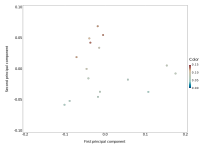

In [12]:
gs_undirected = filter((g) -> !isa(g.graph,typeof(lg.DiGraph())),gs)
gs_filt = [g for g in filter((g) -> (
                # Possibilities are: {asym,sym,bip} {{un,pos,''}{weighted},positive,multisigned}
                contains(get(g.meta,"type","sym unweighted"),"sym unweighted") &&
                #get(g.meta,"type","sym unweighted") == "sym unweighted" &&
                !contains(get(g.meta,"long-description",""), "loop") &&
                !contains(get(g.meta,"category",""), "Generated") &&
                contains(get(g.meta,"category",""), "Animal") &&
                contains(get(g.meta,"name",""), "undirected") &&
                (length(filter((x)->x!=0,diag(lg.adjacency_matrix(g.graph)))) == 0)
),gs_undirected)]
#gs_filt = filter((g) -> g.meta["category"] != "aliens",gs_undirected)
(datamat, dmap, rmap) = blFeats.getdatamat(gs_filt,"motif_4")
#(datamat, dmap, rmap) = blFeats.getdatamat(gs_filt,"motif_4_norm")
colours = [lg.density(g.graph) for g in gs_filt]
labels = [get(g.meta,"name","") for g in gs_filt]
(pcaplot, model, data) = plotdatamatlabels(datamat,labels,colours)
#(pcaplot, data) = plotmodellabels(model,labels,[2,3])
pcaplot
#gf.draw(gf.PDF("erdos_renyi_motif_PCA_density_as_type_assorted_network_sizes.pdf",8gf.inch,6gf.inch),pcaplot)

# somewhere, something is misbehaving... leave it for a bit and come back once you've written something!

In [13]:
gs_filt_notanimals = [g for g in filter((g) -> (
                # Possibilities are: {asym,sym,bip} {{un,pos,''}{weighted},positive,multisigned}
                #contains(get(g.meta,"type","sym unweighted"),"sym unweighted") &&
                #get(g.meta,"type","sym unweighted") == "sym unweighted" &&
                #!contains(get(g.meta,"long-description",""), "loop") &&
                !contains(get(g.meta,"type","sym unweighted"),"bip") &&
                !contains(get(g.meta,"type","sym unweighted"),"asym") &&
                !contains(get(g.meta,"category",""), "Generated") &&
                !contains(get(g.meta,"category",""), "Animal") &&
                lg.nv(g.graph) < 400 &&
                !contains(get(g.meta,"name",""), "undirected") &&
                (length(filter((x)->x!=0,diag(lg.adjacency_matrix(g.graph)))) == 0)
),gs_undirected)]
# Problem is with one of the Animal graphs!

gs_filt2 = [gs_filt..., gs_filt_notanimals...]

26-element Array{blFeats.GraphAndMeta,1}:
 blFeats.GraphAndMeta({84, 196} undirected simple Int64 graph, Dict{String,Any}(Pair{String,Any}("name", "AkatoreA_undirected"),Pair{String,Any}("location", "/home/olie/Dropbox_work/julia_graph_cache/"),Pair{String,Any}("cite", "Thompson & Townsend"),Pair{String,Any}("category", "Animal")), Dict{String,Any}(Pair{String,Any}("motif_4", Dict(UInt64[0x3000000000000000, 0x3000000000000000, 0xd000000000000000, 0xe000000000000000]=>0.000112108,UInt64[0x1000000000000000, 0x3000000000000000, 0x5000000000000000, 0xe000000000000000]=>0.00431614,UInt64[0x2000000000000000, 0x1000000000000000, 0x9000000000000000, 0x6000000000000000]=>0.467096,UInt64[0x1000000000000000, 0x1000000000000000, 0x1000000000000000, 0xe000000000000000]=>0.478756,UInt64[0x6000000000000000, 0x9000000000000000, 0x9000000000000000, 0x6000000000000000]=>0.0497197)),Pair{String,Any}("motif_5", Dict(UInt64[0x0800000000000000, 0x1800000000000000, 0x1800000000000000, 0x6800000000000000, 0xf

In [14]:
#directinname = (g) -> get(g.meta,"type","sym unweighted") == "sym unweighted"
directinname = (g) -> contains(get(g.meta,"name","sym unweighted"), "undirected")

# _norm gives us worse results. Maybe we're accidentally controlling for more than density?
# tangential: how do we stop PCA being clobbered by outliers?

(::#107) (generic function with 1 method)

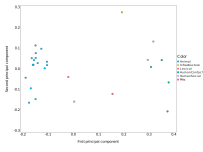

In [15]:
(datamat, dmap, rmap) = blFeats.getdatamat(gs_filt2,"motif_4")
#colours = [lg.density(g.graph) for g in gs_filt2]
colours = [get(g.meta,"category","") for g in gs_filt2]
labels = [get(g.meta,"name","") for g in gs_filt2]
#labels = [directinname(g) for g in gs_filt2]
(pcaplot, model, data) = plotdatamatlabels(datamat,labels,colours)
#(pcaplot, data) = plotmodellabels(model,labels,[2,3])
pcaplot

# There's almost a conclusion here: we can distinguish between (undirected) ecological and human networks
#gf.draw(gf.PDF("Ecological vs Human unnormed 5 motif.pdf",8gf.inch,3gf.inch),pcaplot)

In [16]:
components = ScikitLearn.get_components(model)
DIMENSION = 1
# 2 most likely motifs in first dimension
@show sum(sort(components[DIMENSION,:],rev=true)[end])
best_motifs = [rmap[i] for i in sortperm(components[DIMENSION,:],rev=true)];
nauty.label_to_adj(best_motifs[1])

sum((sort(components[DIMENSION, :], rev=true))[end]) = -0.5192228938687805


4×4 Array{Int64,2}:
 0  0  0  1
 0  0  1  1
 0  1  0  1
 1  1  1  0

In [17]:
# 2 least likely motifs in first dimension
@show sum(sort(components[2,:],rev=false)[1:2])

sum((sort(components[2, :], rev=false))[1:2]) = -0.7684165162993097


-0.7684165162993097

In [18]:
any([length(filter((x)->x==1,diag(lg.adjacency_matrix(g.graph)))) > 0 for g in gs_filt])
# No self loops...
# Are there really any motifs with self loops turning up?
# Answer: no.
# So... now we're just looking at density. 10/10

false

In [19]:
function drawnauty(nautylabel)
    gp.gplot(
        lg.Graph(
            nauty.label_to_adj(
                nautylabel
            )
        )
    )
end

# todo
# check this runs ok on laptop for train
# make sure jupyter is set up sensibly
# linearly interpolate between the motif dict things!

drawnauty (generic function with 1 method)

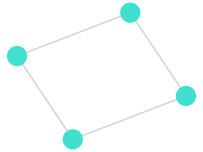

In [346]:
drawnauty(best_motifs[end-2])

In [24]:
filter(x->x!=0,diag.(lg.adjacency_matrix.([g.graph for g in gs_filt]))[1])

0-element Array{Int64,1}

In [25]:
# some graphs have self-loops despite telling us otherwise...
any([length(filter((x)->x!=0,diag(lg.adjacency_matrix(g.graph)))) > 0 for g in gs_filt])

false

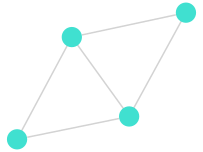

In [28]:
# how can I deal with a motif that literally never shows up?
# use the "rule of succession": https://www.wikiwand.com/en/Rule_of_succession
drawnauty(UInt64[0x3000000000000000, 0x3000000000000000, 0xd000000000000000, 0xe000000000000000])

In [154]:
contact_gs = [g for g in filter((g) -> (
                # Possibilities are: {asym,sym,bip} {{un,pos,''}{weighted},positive,multisigned}
                #contains(get(g.meta,"type","sym unweighted"),"sym unweighted") &&
                #get(g.meta,"type","sym unweighted") == "sym unweighted" &&
                #!contains(get(g.meta,"long-description",""), "loop") &&
                contains(get(g.meta,"category",""), "HumanContact") &&
                (length(filter((x)->x!=0,diag(lg.adjacency_matrix(g.graph)))) == 0)
),gs_undirected)]

#[g.meta.cite for g in contact_gs]

5-element Array{blFeats.GraphAndMeta,1}:
 blFeats.GraphAndMeta({274, 2124} undirected simple Int64 graph, Dict{String,Any}(Pair{String,Any}("code", "HA"),Pair{String,Any}("name", "Haggle"),Pair{String,Any}("long-description", "This undirected network represents contacts between people measured by carried wireless devices. A node represents a person; an edge between two persons shows that there was a contact between them."),Pair{String,Any}("location", "/home/olie/Dropbox_work/julia_graph_cache/"),Pair{String,Any}("extr", "contact"),Pair{String,Any}("description", "Person–person contacts"),Pair{String,Any}("category", "HumanContact"),Pair{String,Any}("url", "http://www.cl.cam.ac.uk/research/srg/netos/haggle/"),Pair{String,Any}("relationship-names", "contact"),Pair{String,Any}("cite", "konect:chaintreau07")…), Dict{String,Any}(Pair{String,Any}("motif_4", Dict(UInt64[0x3000000000000000, 0x3000000000000000, 0xd000000000000000, 0xe000000000000000]=>0.110094,UInt64[0x6000000000000000, 0x9000

In [30]:
erds = blFeats.loadall("*erdos*")

978-element Array{blFeats.GraphAndMeta,1}:
 blFeats.GraphAndMeta({1000, 4967} undirected simple Int64 graph, Dict{String,Any}(Pair{String,Any}("name", "LightGraphs.erdos_renyi1000_0.01_8vpp5ZnqI2qeKVdH30xLr0BBfp25muQW"),Pair{String,Any}("location", "/home/olie/Dropbox_work/julia_graph_cache/"),Pair{String,Any}("function", LightGraphs.erdos_renyi),Pair{String,Any}("args", (1000, 0.01)),Pair{String,Any}("category", "Generated")), Dict{String,Any}(Pair{String,Any}("motif_4", Dict(UInt64[0x3000000000000000, 0x3000000000000000, 0xd000000000000000, 0xe000000000000000]=>4.37419e-5,UInt64[0x1000000000000000, 0x3000000000000000, 0x5000000000000000, 0xe000000000000000]=>0.00780637,UInt64[0x2000000000000000, 0x1000000000000000, 0x9000000000000000, 0x6000000000000000]=>0.74306,UInt64[0x1000000000000000, 0x1000000000000000, 0x1000000000000000, 0xe000000000000000]=>0.247275,UInt64[0x6000000000000000, 0x9000000000000000, 0x9000000000000000, 0x6000000000000000]=>0.00181529))))                         

In [327]:
# i.e, pretty much the same results as if we do the clustering coefficient - but we get much better separation with the motifs
sort([(mean(lg.local_clustering_coefficient(g.graph)), g.meta["name"], g.meta["category"]) for g in gs_filt2])


26-element Array{Tuple{Float64,String,String},1}:
 (0.0103524, "SuttonSp_undirected", "Animal")    
 (0.0215427, "Catlins_undirected", "Animal")     
 (0.0216646, "Troy_undirected", "Animal")        
 (0.0230613, "SuttonAu_undirected", "Animal")    
 (0.0259241, "Coweeta17_undirected", "Animal")   
 (0.0264291, "DempstersSp_undirected", "Animal") 
 (0.0298481, "AkatoreA_undirected", "Animal")    
 (0.035849, "Berwick_undirected", "Animal")      
 (0.0431615, "Blackrock_undirected", "Animal")   
 (0.0482265, "Kyeburn_undirected", "Animal")     
 (0.0545766, "AkatoreB_undirected", "Animal")    
 (0.0574721, "LilKyeburn_undirected", "Animal")  
 (0.0575344, "Coweeta1_undirected", "Animal")    
 (0.0644664, "Martins_undirected", "Animal")     
 (0.0918275, "Healy_undirected", "Animal")       
 (0.114318, "NorthCol_undirected", "Animal")     
 (0.175914, "David Copperfield", "Lexical")      
 (0.477648, "Contiguous USA", "Infrastructure")  
 (0.485671, "Zachary karate club", "HumanSocial")


In [322]:
mean([1,2])

1.5

In [312]:
gs_filt_directed = [g for g in filter((g) -> (
                # Possibilities are: {asym,sym,bip} {{un,pos,''}{weighted},positive,multisigned}
                #contains(get(g.meta,"type","sym unweighted"),"sym unweighted") &&
                #get(g.meta,"type","sym unweighted") == "sym unweighted" &&
                #!contains(get(g.meta,"long-description",""), "loop") &&
                !contains(get(g.meta,"type","sym unweighted"),"bip") &&
                contains(get(g.meta,"type","sym unweighted"),"asym") &&
                (length(filter((x)->x!=0,diag(lg.adjacency_matrix(g.graph)))) == 0)
),gs)]

# Somehow the directed networks are showing up as undirected - is there an error in how we are importing them?

20-element Array{blFeats.GraphAndMeta,1}:
 blFeats.GraphAndMeta({2539, 10454} undirected simple Int64 graph, Dict{String,Any}(Pair{String,Any}("code", "ME"),Pair{String,Any}("name", "Adolescent health"),Pair{String,Any}("long-description", "This directed network was created from a survey that took place in 1994/1995. Each student was asked to list his 5 best female and his 5 male friends. A node represents a student and an edge between two students shows that the left student chose the right student as a friend. Higher edge weights indicate more interactions and a edge weight shows that there is no common activity at all."),Pair{String,Any}("location", "/home/olie/Dropbox_work/julia_graph_cache/"),Pair{String,Any}("extr", "moreno"),Pair{String,Any}("description", "Student–student friendships"),Pair{String,Any}("category", "HumanSocial"),Pair{String,Any}("url", "http://moreno.ss.uci.edu/data.html#health"),Pair{String,Any}("relationship-names", "friendship"),Pair{String,Any}("cite", "kon

In [311]:
gs_directed = filter((g) -> isa(g.graph,typeof(lg.DiGraph())),gs)

# pca for inventing new metrics troubles: only linear combinations; no "k^2" etc; but could happily move to a non-linear dim red

22-element Array{blFeats.GraphAndMeta,1}:
 blFeats.GraphAndMeta({84, 196} directed simple Int64 graph, Dict{String,Any}(Pair{String,Any}("name", "AkatoreA"),Pair{String,Any}("location", "/home/olie/Dropbox_work/julia_graph_cache/"),Pair{String,Any}("cite", "Thompson & Townsend"),Pair{String,Any}("category", "Animal")), Dict{String,Any}(Pair{String,Any}("motif_4", Dict(UInt64[0x0000000000000000, 0x2000000000000000, 0x8000000000000000, 0x2000000000000000]=>0.0242713,UInt64[0x0000000000000000, 0x0000000000000000, 0x1000000000000000, 0xc000000000000000]=>0.00695067,UInt64[0x0000000000000000, 0x0000000000000000, 0xc000000000000000, 0xa000000000000000]=>5.60538e-5,UInt64[0x0000000000000000, 0x8000000000000000, 0x8000000000000000, 0x6000000000000000]=>0.00263453,UInt64[0x0000000000000000, 0x8000000000000000, 0xc000000000000000, 0xc000000000000000]=>5.60538e-5,UInt64[0x0000000000000000, 0x8000000000000000, 0x8000000000000000, 0xc000000000000000]=>0.000280269,UInt64[0x0000000000000000, 0x800000